In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras import layers, models
from IPython.display import Audio
from sklearn.model_selection import train_test_split

In [ ]:
os.chdir("/content/drive/MyDrive/ML/final/")
PATH = 'TaiwanTornado'
file_dir = os.listdir(PATH)
file_dir.sort()

training_samples = len(file_dir)
X_train = np.zeros([training_samples, 132300])
for idx, filename in enumerate(file_dir):
  audio, sr = librosa.load(os.path.join(PATH, filename), sr = 44100, duration = 3)
  audio = librosa.util.fix_length(audio, size=132300)
  # S_full, phase = librosa.magphase(librosa.stft(audio))
  # S_filter = librosa.decompose.nn_filter(S_full,aggregate=np.median,metric='cosine',width=int(librosa.time_to_frames(3, sr=sr)))
  # S_filter = np.minimum(S_full, S_filter)
  # margin_i, margin_v = 2, 10
  # power = 2
  # mask_i = librosa.util.softmask(S_filter,margin_i * (S_full - S_filter),power=power)
  # mask_v = librosa.util.softmask(S_full - S_filter,margin_v * S_filter,power=power)
  # audio = mask_v * S_full
  # S_background = mask_i * S_full
  if audio is not None:
      X_train[idx,:] = audio
print(X_train.shape)

(600, 132300)


In [ ]:
X_train = X_train[:500]

In [ ]:
# 5 categories
data = pd.read_csv("final_label_600.csv", header = None)
for i in range(data.shape[0]):
  if data.loc[i, 0] == 'fearful':
    data.loc[i, 0] = 0
  elif data.loc[i, 0] == 'angry':
    data.loc[i, 0] = 1
  elif data.loc[i, 0] == 'sad':
    data.loc[i, 0] = 2
  elif data.loc[i, 0] == 'happy':
    data.loc[i, 0] = 3
  elif data.loc[i, 0] == 'neutral':
    data.loc[i, 0] = 4

# binary
# data = pd.read_csv("final_label_binary.csv", header = None)

y_train = data.to_numpy()
y_train = tf.keras.utils.to_categorical(y_train)
print(y_train.shape, np.unique(y_train))
data

(600, 5) [0. 1.]


,0
0,0
1,1
2,4
3,1
4,4
...,...
595,0
596,2
597,2
598,0


In [ ]:
def vocal_separation(audio):
  # We'll compare frames using cosine similarity, and aggregate similar frames
  # by taking their (per-frequency) median value.
  #
  # To avoid being biased by local continuity, we constrain similar frames to be
  # separated by at least 2 seconds.
  #
  # This suppresses sparse/non-repetetitive deviations from the average spectrum,
  # and works well to discard vocal elements.
  S_full, phase = librosa.magphase(librosa.stft(audio))
  S_filter = librosa.decompose.nn_filter(S_full,
                                        aggregate=np.median,
                                        metric='cosine',
                                        width=int(librosa.time_to_frames(1, sr=sr)))

  # The output of the filter shouldn't be greater than the input
  # if we assume signals are additive.  Taking the pointwise minimum
  # with the input spectrum forces this.
  S_filter = np.minimum(S_full, S_filter)

  # We can also use a margin to reduce bleed between the vocals and instrumentation masks.
  # Note: the margins need not be equal for foreground and background separation
  margin_i, margin_v = 2, 10
  power = 2

  mask_i = librosa.util.softmask(S_filter,
                                margin_i * (S_full - S_filter),
                                power=power)

  mask_v = librosa.util.softmask(S_full - S_filter,
                                margin_v * S_filter,
                                power=power)

  # Once we have the masks, simply multiply them with the input spectrum
  # to separate the components

  S_foreground = mask_v * S_full
  S_background = mask_i * S_full
  y_foreground = librosa.istft(S_foreground * phase)
  y_foreground = librosa.util.fix_length(y_foreground, size=132300)
  return y_foreground

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
# X_train_vocal = X_train.copy()
# for idx in range(0, len(X_train)):
#   X_train[idx] = vocal_separation(X_train[idx])
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(480, 132300) (120, 132300) (480, 5) (120, 5)


In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [ ]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=512, frame_step=512)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_ds_spec = make_spec_ds(train_data)
val_ds_spec = make_spec_ds(val_data)

In [ ]:
BATCH_SIZE = 8
train_ds_spec = train_ds_spec.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds_spec = val_ds_spec.cache().batch(BATCH_SIZE).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
train_ds_spec.element_spec

(TensorSpec(shape=(None, 258, 257, 1), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))

In [ ]:
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_ds_spec.map(map_func=lambda spec, label: spec))
tf.keras.backend.clear_session()
model = models.Sequential([
    layers.Input(shape=(258,257,1)),
    # Downsample the input.
    # layers.Resizing(256, 256),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    # layers.Reshape((-1, 128)),
    layers.TimeDistributed(layers.Flatten()),
    layers.LSTM(256),
    layers.Dropout(0.25),
    layers.Dense(5),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Activation('relu'),
    layers.Dense(5, activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 258, 257, 1)      3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 256, 255, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 256, 255, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 255, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 127, 32)     0         
 )                                                               
                                                        

In [ ]:
model.load_weights('model.h5')

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [ ]:
model.save_weights('model.h5')

Epoch 1/50
60/60 [==============================] - 7s 35ms/step - loss: 1.8047 - accuracy: 0.2958 - val_loss: 1.5470 - val_accuracy: 0.3667
Epoch 2/50
60/60 [==============================] - 1s 25ms/step - loss: 1.7784 - accuracy: 0.2667 - val_loss: 1.5380 - val_accuracy: 0.3250
Epoch 3/50
60/60 [==============================] - 1s 25ms/step - loss: 1.7444 - accuracy: 0.2479 - val_loss: 1.5147 - val_accuracy: 0.3833
Epoch 4/50
60/60 [==============================] - 1s 25ms/step - loss: 1.7067 - accuracy: 0.2750 - val_loss: 1.5003 - val_accuracy: 0.4167
Epoch 5/50
60/60 [==============================] - 1s 25ms/step - loss: 1.6542 - accuracy: 0.2896 - val_loss: 1.4491 - val_accuracy: 0.4583
Epoch 6/50
60/60 [==============================] - 2s 25ms/step - loss: 1.6608 - accuracy: 0.2979 - val_loss: 1.4696 - val_accuracy: 0.3833
Epoch 7/50
60/60 [==============================] - 2s 25ms/step - loss: 1.6262 - accuracy: 0.3083 - val_loss: 1.5787 - val_accuracy: 0.4167
Epoch 8/50
60

Text(0, 0.5, 'Accuracy [%]')

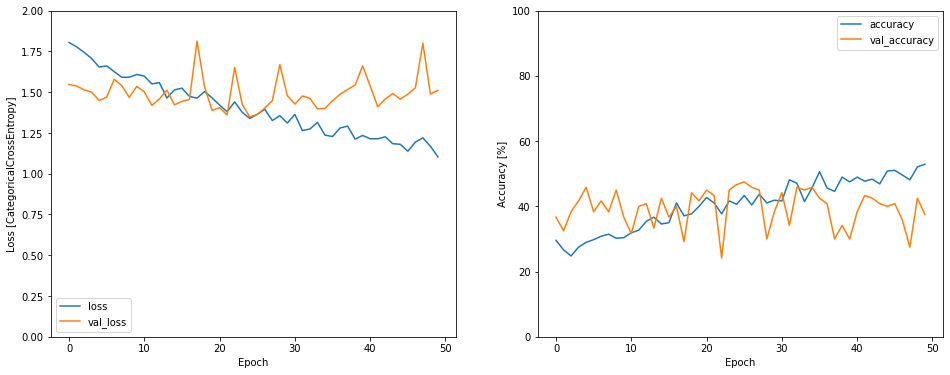

In [ ]:
EPOCHS = 50
history = model.fit(
    train_ds_spec,
    validation_data=val_ds_spec,
    epochs=EPOCHS,
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, 2])
plt.xlabel('Epoch')
plt.ylabel('Loss [CategoricalCrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
# plt.ylim([50, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

Text(0, 0.5, 'Accuracy [%]')

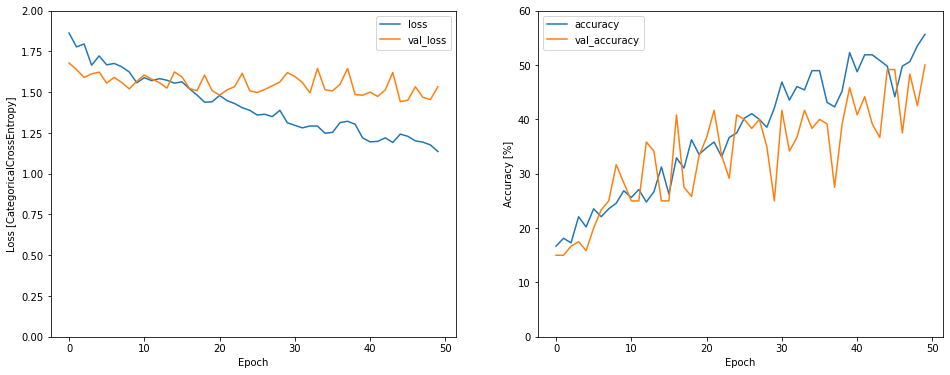

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, 2])
plt.xlabel('Epoch')
plt.ylabel('Loss [CategoricalCrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
# plt.ylim([0, 100])
plt.ylim([0, 60])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [ ]:
pre = model.predict(train_ds_spec)
np.argmax(pre,axis=1)

7/7 [==============================] - 0s 33ms/step


array([1, 4, 1, 2, 1, 4, 1, 4, 2, 3, 3, 1, 0, 1, 3, 4, 2, 2, 1, 0, 2, 1,
       0, 3, 0, 3, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1, 4, 4, 3, 0, 4, 4, 4, 4,
       4, 3, 3, 3, 2, 1, 0, 4, 1, 2, 0, 1, 0, 0, 3, 1, 0, 0, 0, 4, 1, 1,
       2, 1, 2, 0, 2, 1, 4, 0, 2, 2, 2, 1, 1, 2, 1, 1, 0, 4, 3, 0, 2, 2,
       0, 4, 2, 3, 1, 1, 0, 4, 1, 2, 2, 1, 0, 0, 4, 1, 0, 2, 2, 1, 2, 0,
       1, 4, 3, 1, 1, 1, 1, 2, 4, 2, 1, 4, 4, 1, 2, 1, 4, 1, 3, 1, 2, 2,
       2, 3, 0, 1, 3, 1, 3, 0, 1, 4, 4, 0, 4, 2, 2, 1, 2, 2, 2, 3, 3, 3,
       2, 1, 3, 1, 0, 1, 2, 0, 1, 4, 2, 2, 3, 2, 4, 2, 4, 2, 2, 2, 0, 1,
       2, 2, 0, 0, 0, 0, 4, 0, 0, 4, 2, 0, 4, 2, 0, 1, 4, 3, 2, 1, 0, 2,
       4, 1])